# Multicollinearity

## Definition:

Define a multivariate linear regression model such that

$Y_i = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + \cdots + \beta_p X_{pi} + \varepsilon_i$ for $i = 1, 2, \cdots, n$ and $\varepsilon_i$ ~ $N(0, \sigma^2)$ for any $i$

if $Corr(X_i, X_j) >> 0$ for any $i \neq j$, we can say that some of the predictor variables are **linearly correlated** and this regression model has **multicolinearity**.

## Description:

Multicollinearity occurs in regression analysis when several predictor variables within a multiple regression model exhibit **strong correlations** with each other. This means that the value of one predictor can be expressed as a linear combination of other predictor variables. This instability hinders the accurate determination of the individual relationships between each predictor and the dependent variable and leads to a decrease in statistical significance of each predictor variable.

## Demonstration and Diagram:

In [155]:
# Libraries
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from sklearn.decomposition import PCA

# Download real world data where some of the exog variables are correlated
# We will use AAPL, GOOG, MSFT, TLT, AMZN, NVDA as exogenous (predictor) variables
# to fit a multivariate regression model to predict TSLA values as endogenous (dependent) variables
# We will look at the data for the last 5 years
end = datetime.datetime.now()
timedelta = datetime.timedelta(5 * 365)  # last 5 years
start = end - timedelta
df_raw = yf.download(["AAPL", "GOOG", "MSFT", "TLT", "TSLA", "NVDA", "AMZN"], start, end)["Adj Close"]  # use adjusted close column

# We'll use daily returns as the main dataframe for our model
df = df_raw.pct_change()
df = df.dropna()
# Show first few rows of dataframe
df.head()

[*********************100%%**********************]  7 of 7 completed


,AAPL,AMZN,GOOG,MSFT,NVDA,TLT,TSLA
Date,,,,,,,
2018-12-13,0.010940,-0.003102,-0.001673,0.003392,-0.000067,-0.002366,0.027796
2018-12-14,-0.031997,-0.040081,-0.018646,-0.031247,-0.016388,0.003473,-0.029406
2018-12-17,-0.009307,-0.044600,-0.024537,-0.029614,-0.019597,0.005823,-0.047278
2018-12-18,0.012993,0.020100,0.011982,0.010497,0.023402,0.005989,-0.032690
2018-12-19,-0.031192,-0.036352,-0.005541,-0.002693,-0.057371,0.013211,-0.012046


          AAPL      AMZN      GOOG      MSFT      NVDA       TLT      TSLA
AAPL  1.000000  0.627944  0.678173  0.762983  0.660099 -0.139694  0.491701
AMZN  0.627944  1.000000  0.667646  0.688408  0.604592 -0.013148  0.441430
GOOG  0.678173  0.667646  1.000000  0.757493  0.626875 -0.099120  0.410888
MSFT  0.762983  0.688408  0.757493  1.000000  0.706435 -0.121411  0.459611
NVDA  0.660099  0.604592  0.626875  0.706435  1.000000 -0.063072  0.501211
TLT  -0.139694 -0.013148 -0.099120 -0.121411 -0.063072  1.000000 -0.054060
TSLA  0.491701  0.441430  0.410888  0.459611  0.501211 -0.054060  1.000000


<Axes: >

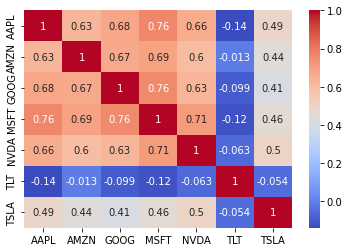

In [156]:
# Look at the correlation matrix for exog variables
exog_corr = df.iloc[:, :7].corr()
# Print the exogenous correlation matrix
print(exog_corr)
# Plot the exogenous correlation matrix
sns.heatmap(exog_corr, annot=True, cmap='coolwarm')

As we can see in the correlation matrix and the plot, because all show relatively high correlations $(\rho > 0.6)$ with each other apart from **TLT**, we can say this group of exogenous variables may have a **multicolinearity** issue. Therefore, we can expect to reduce the dimensionality and complexity of our data after we apply **dimensionality reduction methods** to our dataframe, making each variable relatively more useful in explaining variation.

## Diagnosis

We can detect **multicollinearity** initially by creating a **correlation matrix** of the exogenous (predictor) variables. If at least one pair shows high Pearson correlation ($\rho > 0.6$), we can suspect that our set of predictor variables has a **multicollinearity** problem. However, to formally decide the dataset has multicollinearity, we use a metric called **Variance Inflation Factor (VIF)**, <u> which is calculated for each of the predictor variables </u> :

$VIF_{exog} = \Large\frac{1}{R^2}$

where $R^2$ is the coefficient of determination when fitting an OLS model to a single exogenous variable while using others as the predictors. An independent variable with a **VIF** greater than $5$ indicates <u> severe </u> multicollinearity.

In [157]:
# Fit a basic OLS model
model_ols = smf.ols("TSLA ~ AAPL + AMZN + GOOG + MSFT + NVDA + TLT", df).fit()
# Create label list for exog variables
labels = ["AAPL", "AMZN", "GOOG", "MSFT", "NVDA", "TLT"]
# Define variables
variables = model_ols.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# Show the results in a dataframe
pd.DataFrame(vif[1:], index=labels, columns=["VIF"])

,VIF
AAPL,2.741581
AMZN,2.233624
GOOG,2.713216
MSFT,3.728389
NVDA,2.246821
TLT,1.036678


In [158]:
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TSLA   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     92.30
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           5.29e-96
Time:                        18:06:04   Log-Likelihood:                 2462.0
No. Observations:                1257   AIC:                            -4910.
Df Residuals:                    1250   BIC:                            -4874.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.001      0.996      0.319      -0.001       0.003
AAPL           0.4579      0.078      5.870      0.000       0.305       0.611
AMZN           0.2486      0.064      3.877      0.000       0.123       0.374
GOOG          -0.0223      0.079     -0.282      0.778      -0.177       0.133
MSFT           0.0219      0.096      0.228      0.820      -0.167       0.210
NVDA           0.3348      0.044      7.565      0.000       0.248       0.422
TLT           -0.0122      0.089     -0.137      0.891      -0.186       0.162
==============================================================================
Omnibus:                      121.413   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              778.777
Skew:                           0.137   Prob(JB):                    7.78e-170
Kurtosis:                       6.846   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Although our results indicate that there is only mild multicollinearity $(1 < VIF < 5)$ , we can still work towards reducing the complexity of our data and making our predictor variables more useful.

## Damage

**Multicollinearity** in a regression model can have severe consequences if it is not taken care of:

* High correlation among independent variables in a regression model leads to increased standard errors for coefficient estimates $\hat{\beta_i}$, resulting in less precise coefficient estimates with wider confidence intervals.

* Multicollinearity may reduce the distinct impact of each variable, despite potentially high $R^2$ values.

As a result, **multicollinearity** decreases our confidence in the regression model and our estimates, and may lead to scraping of the model completely if not handled properly.

## 6) Directions

Although we can use several methods such as dropping exogenous variables with high correlations and fitting regressions to the exogenous variables themselves; an industry standard is to use **Principal Component Analysis (PCA)** to address the issue of **multicollinearity**. Principal Component Analysis creates new variables that are <u> linear combinations of the original predictor variables </u> which explain most of the **variation** in the data, thus letting us pick the principal components which provide the most information; effectively letting us reduce the complexity of our data.

In [159]:
# Create dataframe only consisting of exogenous variables (excludes TSLA)
exog_df = df.iloc[:, :6]

# Standardize our data for PCA
std_exog_arr = preprocessing.scale(exog_df)

# Apply PCA to our standardized array of values
pca = PCA(n_components=6)
pca.fit(std_exog_arr)

# Calculate explained variance and cumulative explained variance ratios
ex_var = pca.explained_variance_ratio_
cum_ex_var = np.cumsum(pca.explained_variance_ratio_)

# Put the results into a dataframe
cols = [f"pc{i+1}" for i in range(len(ex_var))]
rows = ["Explained Variance", "Cumulative Explained Variance"]
pca_ex_var_df = pd.DataFrame([ex_var, cum_ex_var], index=rows, columns=cols)
pca_ex_var_df

,pc1,pc2,pc3,pc4,pc5,pc6
Explained Variance,0.621781,0.166689,0.068059,0.058001,0.051089,0.03438
Cumulative Explained Variance,0.621781,0.788471,0.856529,0.914531,0.965620,1.00000


We can see that the first 3 principal components explain ~$85.65$% of the variance. Then, we can confidently fit an OLS model using **pc1**, **pc2** and **pc3**; while dropping the rest of the **pc**s.

In [161]:
# Apply PCA to our standardized array of values and get the principal components
pca_components = pca.transform(std_exog_arr)

# Add the principal components to the dataframe
for i, pc in enumerate(cols[:3]):
    df[pc] = pca_components[:, i]
    
# Fit an OLS model using pc1, pc2 and pc3
model_pca_OLS = smf.ols("TSLA ~ pc1 + pc2 + pc3", df).fit()
model_pca_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TSLA   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     174.5
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           1.52e-94
Time:                        18:06:05   Log-Likelihood:                 2450.9
No. Observations:                1257   AIC:                            -4894.
Df Residuals:                    1253   BIC:                            -4873.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0027      0.001      2.737      0.006       0.001       0.005
pc1           -0.0113      0.001    -22.498      0.000      -0.012      -0.010
pc2            0.0009      0.001      0.915      0.360      -0.001       0.003
pc3            0.0062      0.002      4.077      0.000       0.003       0.009
==============================================================================
Omnibus:                      117.210   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              727.844
Skew:                           0.122   Prob(JB):                    8.93e-159
Kurtosis:                       6.720   Cond. No.                         3.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [162]:
# Correlations between principal components are zero.
df.iloc[:, -3:].corr().round(4)

,pc1,pc2,pc3
pc1,1.0,0.0,-0.0
pc2,0.0,1.0,0.0
pc3,-0.0,0.0,1.0


In [163]:
# Calculate VIF values
pc_vars = model_pca_OLS.model.exog
pc_vif = [variance_inflation_factor(pc_vars, i) for i in range(pc_vars.shape[1])]
# Show the results in a dataframe
pd.DataFrame(pc_vif[1:], index=["pc1", "pc2", "pc3"], columns=["VIF"])

,VIF
pc1,1.0
pc2,1.0
pc3,1.0


As we can see from the results table, while $R^2$ value practically stayed the same at $R^2 =$ ~ $0.3$ but the **VIF** values from the new principal component variables are all equal to $1$ and pairwise correlations between the principal components are ~$0$. Therefore, we can confidently conclude that our principal component analysis ended up improving the **multicollinearity** problem in our dataset and resulted in a better OLS regression model.